In [2]:
import os
import re
import pandas as pd
import regex
from library import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import torch

In [21]:
import numpy as np
from gensim.models import KeyedVectors
import dill
# Define the path to the pre-trained GloVe model file
glove_file = 'glove.twitter.27B.100d.txt'

# Define the format of the pre-trained GloVe model file
def read_glove_file(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    word_to_vec = {}
    for line in lines:
        line = line.strip().split()
        word = line[0]
        vec = np.array([float(val) for val in line[1:]])
        word_to_vec[word] = vec
    return word_to_vec

# Load the pre-trained GloVe model
word_to_vec_map = read_glove_file(glove_file)

def get_word_embedding(sentence):
    # Tokenize the input string into words
    words = sentence.split()

    # Initialize an empty array to store the word embeddings
    embeddings = []

    # Look up the word embeddings for each word in the pre-trained GloVe model
    for word in words:
        try:
            embedding = word_to_vec_map[word.lower()]
            embeddings.append(embedding)
        except KeyError:
            # If the word is not in the vocabulary, skip it
            continue

    # Combine the word embeddings into a single vector
    if len(embeddings) > 0:
        sentence_embedding = np.mean(embeddings, axis=0)
    else:
        sentence_embedding = np.zeros(100)

    return sentence_embedding



In [22]:
def glove(messages):
    embeddings = []
    for msg in messages:
        embeddings.append(get_word_embedding(msg))
    return embeddings

In [3]:
def trac1_dataset_preprocess():
    df1 = load_dataset("agr_hi_train.csv")
    df2 = load_dataset("agr_en_train.csv")
    df = pd.concat([df1,df2])
    df = preprocess_text(df)
    df["message"].fillna('',inplace=True)
    df1 = load_dataset("agr_hi_dev.csv")
    df2 = load_dataset("agr_en_dev.csv")
    val_df = pd.concat([df1,df2])
    val_df = preprocess_text(val_df)
    y_train = df["class"]
    y_test = val_df["class"]
    x_train = df["message"]
    x_test = val_df["message"]
    return x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test = trac1_dataset_preprocess()

In [25]:
xtrain_glove = glove(x_train)

In [28]:
xtest_glove = glove(x_test)

In [29]:
dill.dump_session('glove_embeddings.db')

In [31]:
def embedding_evaluation(x_train,x_test,y_train,y_test,embedding_done = False):
    tfidf_vectorizer = TfidfVectorizer(analyzer=custom_analyzer)
    if not embedding_done:
        tfidf_vectorizer.fit(x_train)
        x_train = tfidf_vectorizer.transform(x_train)
    #labels encoding
    labels = y_train
    le = preprocessing.LabelEncoder()
    labels_encoded=le.fit_transform(labels)
    
    #train with random forest
    clf = RandomForestClassifier(n_estimators=750, max_depth=30, random_state=42)
    clf.fit(x_train, labels_encoded)
    if not embedding_done:
        x_test = tfidf_vectorizer.transform(x_test)
    #test labels encode
    labels = y_test
    labels_encoded=le.transform(labels)
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)
    
    y_pred = clf.predict(x_test)

    accuracy = accuracy_score(labels_encoded, y_pred)
    print("accuracy:   %0.3f" % accuracy)
    print("confusion matrix:")
    cf_matrix = confusion_matrix(labels_encoded, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

{'CAG': 0, 'NAG': 1, 'OAG': 2}
accuracy:   0.552
confusion matrix:


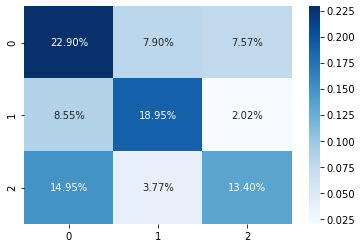

In [33]:
embedding_evaluation(xtrain_glove,xtest_glove,y_train,y_test,embedding_done = True)